# Sage Shaw

### ME 571 - Spring 2018

# HW 2 - Problem 3

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import subprocess
import scipy as sp
import scipy.sparse
import scipy.sparse.linalg
import timeit

In [2]:
%%bash
mpicc demo_util.c p3b.c -o p3b -lm
mpirun -n 16 ./p3b -p 10 > results.csv
head results.csv

In [3]:
def generate_solution(procs, power):
    file = open("results.csv", "w")
    subprocess.run( ['mpirun','-n', str(procs), './p3b','-p',str(power)],stdout=file)
    file.close()
    return np.genfromtxt('results.csv', delimiter=',')

1 loop, best of 1: 65.9 ms per loop


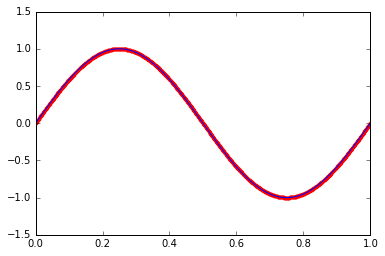

In [4]:
file = open("results.csv", "w")
tr = %timeit -n 1 -r 1 -o w = p = subprocess.run( ['mpirun','-n', str(16), './p3b','-p',str(10)],stdout=file)
file.close()
A = np.genfromtxt('results.csv', delimiter=',')

#A, time = generate_solution(16, 10)
x = A[:,0]
u = A[:,1]
plt.plot(x,u,'r.')
plt.plot(x,np.sin(2*np.pi*x),'b-')

We can visually verify the accuracy of our implementation in the plot above. For a more precise approach we plot the error for several values of $N$ in the plot below.

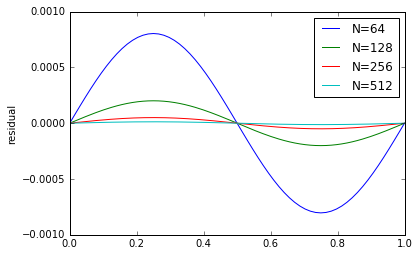

In [5]:
for i in range(6,10):
    N = 2**i
    A = generate_solution(1, i)
    x = A[:,0]
    u = A[:,1]
    plt.plot(x,u-np.sin(2*np.pi*x), label='N='+str(N))
plt.legend()
plt.ylabel('residual')

## Scaling Results

In [10]:
%%capture
#generate data
data = {}
columns = ['Processors', 'Time', 'Error']

for procs in [1, 2, 4, 8, 16]:
    df = pd.DataFrame(columns=columns)
    for power in range(6, 16):
        file = open("results.csv", "w")
        tr = %timeit -n 1 -r 1 -o p = subprocess.run(['mpirun','-n', str(procs), './p3b','-p',str(power)],stdout=file)
        file.close()
        A = np.genfromtxt('results.csv', delimiter=',')
        x = A[:,0]
        u = A[:,1]
        error = np.linalg.norm(u - np.sin(2*np.pi*x))
        data_row = {'Processors': procs, 'Time': tr.best, 'Error':error}
        df = df.append(pd.Series(data=data_row, name=2**power))
    data['p' + '{:02d}'.format(procs) ] = df
panel = pd.Panel(data)

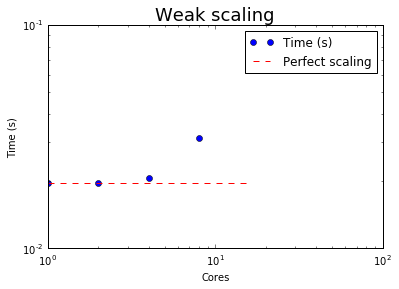

In [11]:
times = np.diag(panel.minor_xs('Time'))
procs = [2**i for i in range(len(times))]

plt.loglog(procs, times, 'bo')

# Plot best-fit speed-up line
t_weak = times

plt.semilogx(procs,[t_weak[0] for p in procs],'r--')

plt.title('Weak scaling', fontsize=18)
plt.xlabel('Cores')
plt.ylabel("Time (s)")
plt.legend(['Time (s)','Perfect scaling'])



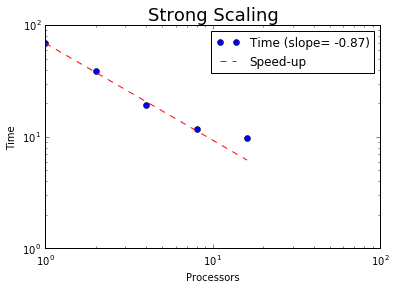

In [12]:
times = np.array(panel.minor_xs('Time'))[-1]
procs = [2**i for i in range(len(times))]
#plt.loglog(procs, times, 'bo')
plt.loglog(procs, times, 'bo')

t_strong = times
c = np.polyfit(np.log(procs[:-1]),np.log(t_strong[:-1]),1)
plt.semilogx(procs,np.exp(np.polyval(c,np.log(procs))),'r--')

plt.legend(['Time (slope={:6.2f})'.format(c[0]),'Speed-up'])
plt.title('Strong Scaling',fontsize=18);
plt.xlabel('Processors')
plt.ylabel('Time')

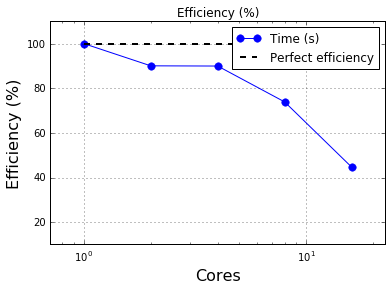

In [17]:
plt.figure()
plt.clf()

# Efficiency
E = t_strong[0]/(procs*t_strong)*100

plt.semilogx(procs,E,'.-',markersize=15)
plt.semilogx(procs,[100]*len(procs),'k--',linewidth=2)

plt.xlabel('Cores',fontsize=16)
plt.ylabel('Efficiency (%)',fontsize=16)
plt.title("Efficiency (%)");
plt.legend(['Time (s)', 'Perfect efficiency'])
plt.xlim([1/np.sqrt(2), 2**4.5])
plt.ylim([10,110])
plt.grid()

# Part d - Finite Difference Comparision

The finite difference approximation to the second derivative is given by
$$
f^{\prime\prime}(x_i) \approx \frac{-2f(x_i)+f(x_{i+1}) + f(x_{i-1})}{h^2}
$$
Approximating the derivative at the internal points gives us the linear system
\begin{align*}
    \begin{bmatrix}
        2 & -1 & & & & \\
        -1 & 2 & -1 & & & \\
        & -1 & 2 & -1 & & \\
        & & \ddots & \ddots & \ddots & \\
        & & & -1 & 2 & -1 \\
        & & & & -1 & 2
    \end{bmatrix}
    \begin{bmatrix}
        u_1 \\
        u_2 \\
        u_3 \\
        \vdots \\
        u_{n-2} \\
        u_{n-1}
    \end{bmatrix}
    =
    \begin{bmatrix}
        a - h^2f(x_1) \\
        -h^2f(x_2) \\
        -h^2f(x_3) \\
        -\vdots \\
        -h^2f(x_{n-2}) \\
        b - h^2f(x_{n-1})
    \end{bmatrix}
\end{align*}

In [152]:
def finite_difference(n):
    a =0
    b = 0
    A = sp.sparse.diags([[2]*n,[-1]*(n-1),[-1]*(n-1)],[0,1,-1])
    h = 1/(n+1)
    xs = [h*i for i in range(1,n+1)]
    xs = np.array(xs).reshape(n,1)
    v = -(2*np.pi)**2 * np.sin(2*np.pi*xs)
    v *= -h**2
    v[0] += b
    v[-1] += a
    u = sp.sparse.linalg.spsolve(A.tocsc(),v)
    return u, np.linalg.norm(u-np.sin(2*np.pi*xs).ravel())

(32767,)
3.91506670042e-07


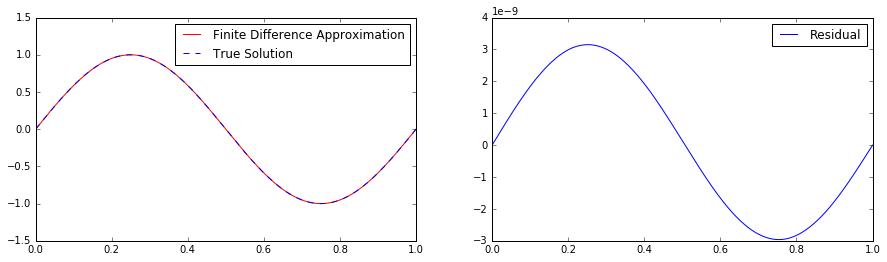

In [143]:
n = 2**15
u, error = finite_difference(n)
h = 1/(n+1)
xs = np.array([h*i for i in range(1,n+1)])

fig, (plt1, plt2) = plt.subplots(1,2)
fig.set_figwidth(15)

plt1.plot(xs,u,'r-')
plt1.plot(xs, np.sin(2*np.pi*xs),'b--')
#plt1.title('Solutions')
plt1.legend(['Finite Difference Approximation','True Solution'])

plt2.plot(xs, u-np.sin(2*np.pi*xs))
plt2.legend(['Residual'])
print(error)

In [ ]:
%%capture
# Timing and error data

Ns = []
fd_times = []
fd_errors = []

p16_times = []
p16_errors = []

for power in range(6, 20):
    print(power, 'Finite Difference')
    N = 2**power - 1
    Ns += [N]
    tr = %timeit -n 1 -r 1 -o u, error = finite_difference(N)
    u, error = finite_difference(N)
    fd_times += [tr.best]
    fd_errors += [error]
    
# More time on 16 Processors
for power in range(6, 20):
        print(power, 'Integral')
        file = open("results.csv", "w")
        tr = %timeit -n 1 -r 1 -o w = p = subprocess.run(['mpirun','-n', str(16), './p3b','-p',str(power)], stdout=file)
        file.close()
        A = np.genfromtxt('results.csv', delimiter=',')
        x = A[:,0]
        u = A[:,1]
        error = np.linalg.norm(u - np.sin(2*np.pi*x))
        p16_times += [tr.best]
        p16_errors += [error]

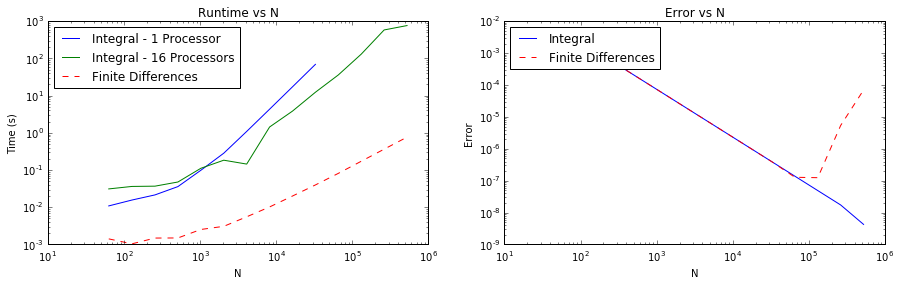

In [187]:
fig, (plt1, plt2) = plt.subplots(1,2)
fig.set_figwidth(15)

p1_times = np.array(panel['p01']['Time'])
#p16_times = np.array(panel['p16']['Time'])

plt1.loglog(Ns[:len(p1_times)], p1_times, 'b-')
plt1.loglog(Ns[:len(p16_times)], p16_times, 'g-')
plt1.loglog(Ns, fd_times,'r--')
plt1.legend(['Integral - 1 Processor','Integral - 16 Processors','Finite Differences'], loc='upper left')
plt1.set_xlabel('N')
plt1.set_ylabel('Time (s)')
plt1.set_title('Runtime vs N')

#int_error = np.array(panel['p01']['Error'])

plt2.loglog(Ns[:len(p16_errors)], p16_errors, 'b-')
plt2.loglog(Ns, fd_errors,'r--')
plt2.legend(['Integral', 'Finite Differences'], loc='upper left')
plt2.set_xlabel('N')
plt2.set_ylabel('Error')
plt2.set_title('Error vs N')


### Finite Difference comparision
Since this matrix is Tridiagonal it can be solved in $\mathcal{O}(N)$ time, far faster than the $\mathcal{O}(N^2)$ time that it takes for the trapezoidal rule applied to $N$ points. Finite difference methods cannot reduce the error below $10^{-7}$ however, because the condition number of the matrix scales with $N$.

# Simpson's Rule

In [208]:
%%bash
mpicc demo_util.c p3e.c -o p3e -lm
mpirun -n 16 ./p3e -p 2 > results.csv
head results.csv

1 loop, best of 1: 79.3 ms per loop


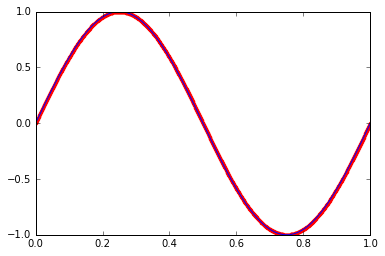

In [209]:
file = open("results.csv", "w")
tr = %timeit -n 1 -r 1 -o w = p = subprocess.run( ['mpirun','-n', str(16), './p3e','-p',str(10)],stdout=file)
file.close()
A = np.genfromtxt('results.csv', delimiter=',')

#A, time = generate_solution(16, 10)
x = A[:,0]
u = A[:,1]
plt.plot(x,u,'r.')
plt.plot(x,np.sin(2*np.pi*x),'b-')

In [210]:
def generate_simp_solution(procs, power):
    file = open("results.csv", "w")
    subprocess.run( ['mpirun','-n', str(procs), './p3e','-p',str(power)],stdout=file)
    file.close()
    return np.genfromtxt('results.csv', delimiter=',')

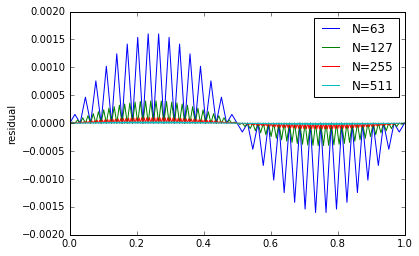

In [211]:
for i in range(6,10):
    N = 2**i-1
    A = generate_simp_solution(1, i)
    x = A[:,0]
    u = A[:,1]
    plt.plot(x,u-np.sin(2*np.pi*x), label='N='+str(N))
plt.legend()
plt.ylabel('residual')

In [ ]:
simp_time = []
simp_error = []

# More time on 16 Processors
for power in range(6, 20):
        print(power, 'Integral')
        file = open("results.csv", "w")
        tr = %timeit -n 1 -r 1 -o w = p = subprocess.run(['mpirun','-n', str(16), './p3e','-p',str(power)], stdout=file)
        file.close()
        A = np.genfromtxt('results.csv', delimiter=',')
        x = A[:,0]
        u = A[:,1]
        error = np.linalg.norm(u - np.sin(2*np.pi*x))
        simp_time += [tr.best]
        simp_error += [error]

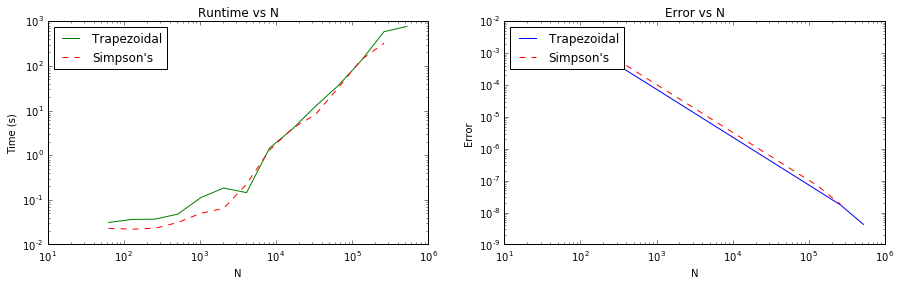

In [214]:
fig, (plt1, plt2) = plt.subplots(1,2)
fig.set_figwidth(15)

#p1_times = np.array(panel['p01']['Time'])
#p16_times = np.array(panel['p16']['Time'])

#plt1.loglog(Ns[:len(p1_times)], p1_times, 'b-')
plt1.loglog(Ns[:len(p16_times)], p16_times, 'g-')
plt1.loglog(Ns[:len(simp_time)], simp_time,'r--')
plt1.legend(['Trapezoidal',"Simpson's"], loc='upper left')
plt1.set_xlabel('N')
plt1.set_ylabel('Time (s)')
plt1.set_title('Runtime vs N')

#int_error = np.array(panel['p01']['Error'])

plt2.loglog(Ns[:len(p16_errors)], p16_errors, 'b-')
plt2.loglog(Ns[:len(simp_time)], simp_error,'r--')
plt2.legend(['Trapezoidal',"Simpson's"], loc='upper left')
plt2.set_xlabel('N')
plt2.set_ylabel('Error')
plt2.set_title('Error vs N')

### Analysis

Of course the time for these algorithms are essentially the same, since all we've done is change the weights and have not reduced the number of computations. Any difference can be attributed to random variability. 

A more interesting, though not unexpected result is that the Simpson's rule approximation is worse than the Trapezoidal rule. This is because we happen to be integrating functions that can be thought of as periodic in a sense. The functions $G(x;t)$ have the same value at both end points and the same derivatives at both end points, and the same second derivatives, and so on. The error term on the trapezoidal rule is given by
$$
\text{error} = -\frac{(b-a)^2}{12}h^2 \big[ f^\prime(b)-f^\prime(a) \big] + \mathcal{O}(h^3)
$$
Since the derivatives are equal, this error term is zero. It can be shown that a similar error term involving the difference between the third derivatives gives the accuracy to $\mathcal{O}(h^5)$, but this is also zero. Induction can show that when applied to periodic functions (or functions that have this particular property for all of their derivatives) that the error is less than $\mathcal{O}(h^p)$ for any power $p$. Simpson's rule has a small error term, but it doesn't benefit from these nice properties.

In reality neither of these error analyses are completely correct since these Green's fuctions can only be differentiated once. I would think that any approximation based on Taylor's theorem would not do better than $\mathcal{O}(h)$ and it appears that is what we see above.

In [217]:
%%bash 
cat p3b.c

# include <math.h>
# include <mpi.h>
# include "demo_util.h"
# include <stdio.h>


double foo(double x){
    return -1*(2*M_PI)*(2*M_PI)*sin(2*M_PI*x);
}

double exact(double x){
    return sin(2*M_PI*x);
}

double goo(double x, double t){
    if(t<x){
        return (x-1)*t*foo(t);
    }else{
        return (t-1)*x*foo(t);
    }
}

double trap_rule(double t0, double t1, double x, long n){
    double h = (t1 - t0)/n;
    double ret = 0.5*(goo(x, t0)+goo(x,t1));
    double step = (t1-t0)/n;
    int i;
    for(i=1; i<n; i++){
        ret += goo(x,t0+step*i);
    }
    return ret*h;
}


int main(int argc, char** argv){

    double a = 0;
    double b = 1;
    double trap_total;
    double* u;    

    int rank, nprocs;

    MPI_Init(&argc, &argv);
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &nprocs);

    //read arguments and broadcast
    long N, n;
    if(rank==0){
        int p, err;
        read_int(argc,argv, "-p", &p, &err);
        N = pow(2,p);
    

In [218]:
%%bash
cat p3e.c

# include <math.h>
# include <mpi.h>
# include "demo_util.h"
# include <stdio.h>


double foo(double x){
    return -1*(2*M_PI)*(2*M_PI)*sin(2*M_PI*x);
}

double exact(double x){
    return sin(2*M_PI*x);
}

double goo(double x, double t){
    if(t<x){
        return (x-1)*t*foo(t);
    }else{
        return (t-1)*x*foo(t);
    }
}

double simp_rule(double t0, double t1, double x, long n){
    double h = (t1 - t0)/n;
    double ret = goo(x, t0)+goo(x,t1);
    double step = (t1-t0)/n;
    int i;
    ret += 4*goo(x,t0+step);
    for(i=2; i<n; i+=2){
        ret += 2*goo(x,t0+step*i);
        ret += 4*goo(x,t0+step*(i+1));
    }
    ret *= h/3.0;
    return ret;
}


int main(int argc, char** argv){

    double a = 0;
    double b = 1;
    double trap_total;
    double* u;    

    int rank, nprocs;

    MPI_Init(&argc, &argv);
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &nprocs);

    //read arguments and broadcast
    long N, n;
    if(rank==0){
        in